# Electricity Usage Analysis

## Problem Description

    
In this challenge, you are asked to explore a dataset describing a household's environmental conditions and electricity usage. The dataset is a time series with variables representing the internal temperature and humidity monitored by sensors, the electricity usage sourced from the energy meter, and external weather conditions provided by a local weather station. All variables have been summarised into 10-minute intervals over a four-month period (2016 January to 2016 May). We are interested in predicting the electricity usage of the household (the variable named 'Appliances' in the dataset) given the internal and external environmental conditions. 


There are three tasks (in detailed task description can be in the later sections) you need to complete:  <br>
1. Modelling 
2. Model Performance 
3. Prediction


## Data Description

Column | Description
:---|:---
`date` |Timestamp
`Appliances` |Energy use in Wh
`lights` |Energy use of light fixtures in the house in Wh 
`T1`	|Temperature in kitchen area, in Celsius
`RH_1`	|Humidity in kitchen area, in % 
`T2`	|Temperature in living room area, in Celsius 
`RH_2`	|Humidity in living room area, in % 
`T3`	|Temperature in laundry room area 
`RH_3`	|Humidity in laundry room area, in % 
`T4`	|Temperature in office room, in Celsius 
`RH_4`	|Humidity in office room, in % 
`T5`	|Temperature in bathroom, in Celsius 
`RH_5`	|Humidity in bathroom, in % 
`T6`	|Temperature outside the building (north side), in Celsius 
`RH_6`	|Humidity outside the building (north side), in %
`T7`	|Temperature in ironing room , in Celsius 
`RH_7` 	|Humidity in ironing room, in % 
`T8` 	|Temperature in teenager room 2, in Celsius 
`RH_8` 	|Humidity in teenager room 2, in % 
`T9` 	|Temperature in parents room, in Celsius 
`RH_9` 	|Humidity in parents room, in % 
`T_out` 	|Temperature outside (from weather station), in Celsius
`Press_mm_hg`   |Pressure (from weather station), in mm Hg
`RH_out`    |Humidity outside (from weather station), in %
`Windspeed` |from weather station, in m/s 
`Visibility`    |from weather station, in km 
`Tdewpoint` |from weather station Â°C
`v1`	|unknown
`v2`	|unknown


    If you'd like to install packages that aren't installed by default. For example in Python, uncomment the last two lines of this cell and replace <package list> with a list of your packages. This will ensure your notebook has all the dependencies and works everywhere

In [587]:
for name in dir():
    if not name.startswith("_"):
        del globals()[name]

In [693]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install Keras
!{sys.executable} -m pip install tensorflow

In [695]:
# Libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

from scipy.stats import skew, kurtosis
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## Modelling Task


> #### Task:
- **Exploration** <br/>
    Explore relationships or patterns in the dataset `dataset_1.csv` and create one or two informative visualisations with related discussions.
- **Modelling** <br/>
    Clean the data, preprocess if needed, choose modelling methods and implement them in you programming language of choice.  (include graphics if needed). Discuss the selected modelling option for the predictions.
  
 
> #### Deliverable:
- Well commented Jupyter notebook 
- Final report (optional)

# 1. Data Exploration and Understanding

In [590]:
df_raw = pd.read_csv('dataset_1.csv', header='infer')
df_raw.set_index('date', inplace=True)

print(df_raw.shape)
df_raw.head()

(17610, 28)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,v2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,NaN,48.863333,NaN,45.56,6.483333,733.6,92.0,6.666667,NaN,5.2,18.606195,18.606195
2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,NaN,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,NaN,6.000000,51.500000,5.0,45.410390,45.410390
2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,NaN,18.1,48.590000,17.000000,45.40,6.133333,733.9,NaN,5.666667,47.666667,4.9,10.084097,10.084097


## 1.1 Missing data

Some sample illustrations of the time series data below

In [591]:
# plot the time series data to visualize the general trend
def plot_timeseries(df, col_list):
    fig, ax = plt.subplots(figsize=(10,6))
    
    xaxis = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in df.index]
    colors = {0: 'r', 1: 'g', 2: 'b'}
    for idx, col in enumerate(col_list):
        plt.plot(xaxis, df[col], linestyle='-', color=colors[idx], label=col)

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
    ax.set_xlabel('Time (Month-Day)')
    plt.legend(loc='upper right')
    plt.show()

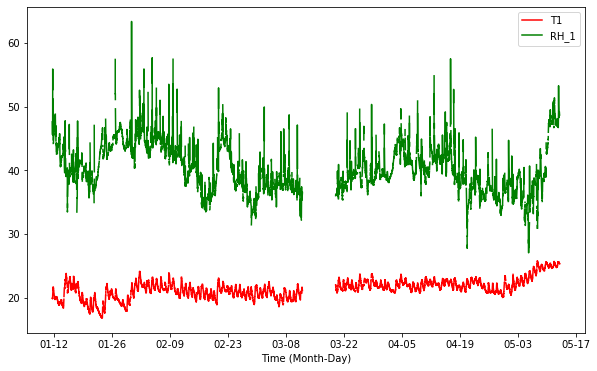

In [592]:
plot_timeseries(df_raw,['T1', 'RH_1'])

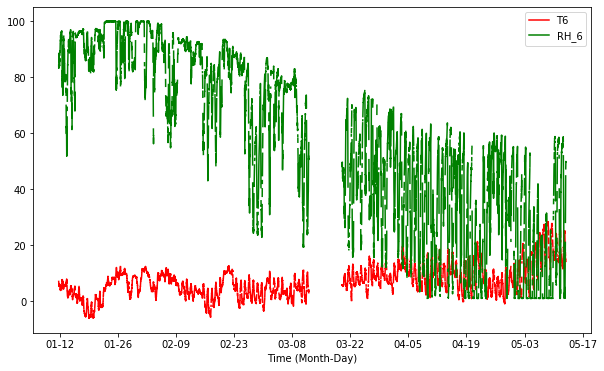

In [593]:
plot_timeseries(df_raw,['T6', 'RH_6'])

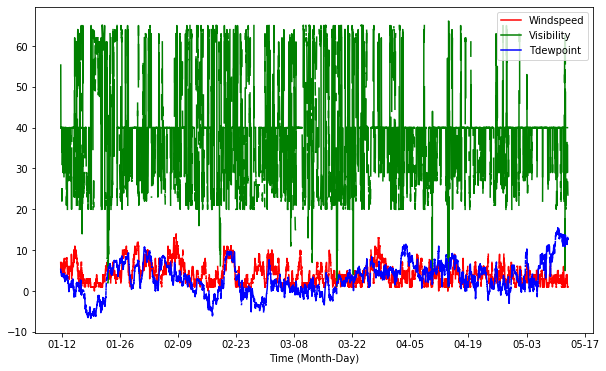

In [594]:
plot_timeseries(df_raw,['Windspeed', 'Visibility', 'Tdewpoint'])

We observe that across the dataset, the timeseries {T1, RH_1, ..., T9, RH_9} have data missing along with that of <i>Appliances</i> for the week of March 12<sup>th</sup>-19<sup>th</sup>. As the target variable's data is missing across this period, I discard this period from the analysis as imputation of missing data for the <i>target variable</i> isn't meaningful.

In [595]:
df_raw[df_raw['Appliances'].isna()].index

Index(['2016-03-12 00:10:00', '2016-03-12 00:20:00', '2016-03-12 00:30:00',
       '2016-03-12 00:40:00', '2016-03-12 00:50:00', '2016-03-12 01:00:00',
       '2016-03-12 01:10:00', '2016-03-12 01:20:00', '2016-03-12 01:30:00',
       '2016-03-12 01:40:00',
       ...
       '2016-03-19 22:20:00', '2016-03-19 22:30:00', '2016-03-19 22:40:00',
       '2016-03-19 22:50:00', '2016-03-19 23:00:00', '2016-03-19 23:10:00',
       '2016-03-19 23:20:00', '2016-03-19 23:30:00', '2016-03-19 23:40:00',
       '2016-03-19 23:50:00'],
      dtype='object', name='date', length=1151)

Understanding the amount of missing data - after the rows with Nan for Appliances are excluded, we still have some missing data for other columns ranging up to 17% for RH_7

In [596]:
df_missing = pd.concat([df_raw.nunique(), df_raw.isnull().any(), df_raw.isnull().mean()], axis=1)
df_missing.columns = ['nunique', 'isnull_any', 'isnull_proportion']

df2 = df_raw[~df_raw['Appliances'].isna()]
df2_missing = pd.concat([df2.nunique(), df2.isnull().any(), df2.isnull().mean()], axis=1)
df2_missing.columns = ['nunique', 'isnull_any', 'isnull_proportion']

pd.merge(df_missing, df2_missing, how='left', left_index=True, right_index=True)

,nunique_x,isnull_any_x,isnull_proportion_x,nunique_y,isnull_any_y,isnull_proportion_y
Appliances,91,True,0.065361,91,False,0.000000
lights,8,True,0.070982,8,True,0.006015
T1,455,True,0.187166,455,True,0.130324
RH_1,1990,True,0.187507,1990,True,0.130688
T2,1000,True,0.194776,1000,True,0.138465
RH_2,2193,True,0.175355,2193,True,0.117686
T3,906,True,0.189495,906,True,0.132815
RH_3,1937,True,0.178365,1937,True,0.120906
T4,1058,True,0.147246,1058,True,0.087612
RH_4,2353,True,0.182964,2353,True,0.125828


## 1.2 Correlation Analysis for Feature Selection

We perform a correlation analysis of all feature pairs to determine strongly correlated features. Identifying such pairs will help us consider a smaller subset of features and aid us in the feature selection process.

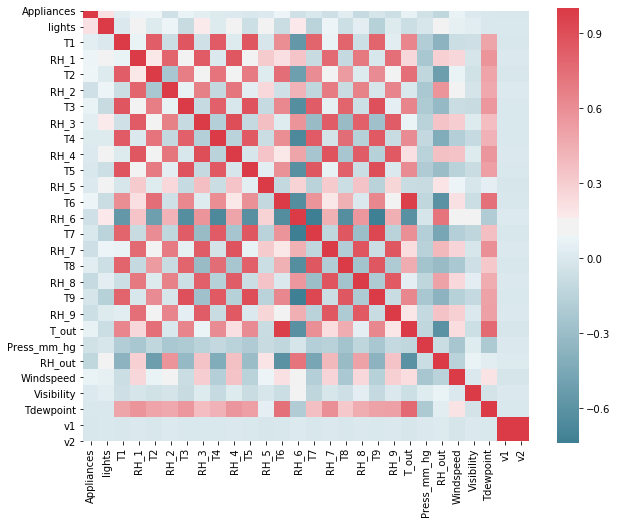

In [597]:
corr_matrix = df2.corr()

f, ax = plt.subplots(figsize=(10, 8))
corr_threshold = 0.9
corr_matrix = df2.corr()
sns.heatmap(
    corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax
)

In [598]:
corr_threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [col for col in upper.columns if any(upper[col].abs() > corr_threshold)]

df_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for col in to_drop:
    corr_feature = list(upper.index[upper[col].abs() > corr_threshold])
    corr_value = list(upper[col][upper[col].abs() > corr_threshold])
    drop_feature = [col for _ in range(len(corr_feature))]
    tmp_df = pd.DataFrame.from_dict({'drop_feature': drop_feature, 'corr_feature': corr_feature, 'corr_value': corr_value})
    
    df_collinear = df_collinear.append(tmp_df, ignore_index=True)
    
df_collinear.sort_values('corr_value', ascending=False)

,drop_feature,corr_feature,corr_value
4,v2,v1,1.000000
3,T_out,T6,0.975110
2,T9,T7,0.932636
1,T9,T5,0.903494
0,RH_4,RH_3,0.900693


The above correlation matrix demonstrates that:
1. v1 and v2 have perfect correlation. In fact, on closer inspection, the values in these two columns are identical to each other, so one of them can be removed.
2. T_out is strongly correlated with T6; T9 is correlated with both T7 and T5 while RH_4 exhibits a strong correlation with RH_3
3. The <b>drop_feature</b> column lists the features that can be excluded in subsequent modelling as there is a corresponding feature with which they are strongly correlated.

In [600]:
# v1 & v2 are identical columns
v1v2_diff = (df_raw['v1'] - df_raw['v2'])
print(v1v2_diff.min())
print(v1v2_diff.max())

0.0
0.0


In [601]:
# features to be excluded from the analysis based on a correlation threshold of 0.90
exclude_cols = list(np.unique(df_collinear['drop_feature']))
exclude_cols

['RH_4', 'T9', 'T_out', 'v2']

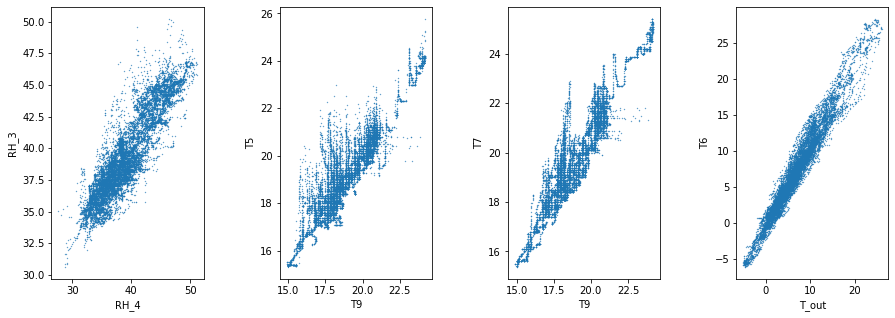

In [602]:
# scatter plots of the above correlated feature pairs

fig, ax = plt.subplots(1, 4, figsize=(15, 5))

plt.subplots_adjust(wspace = 0.5)
plt.subplot(1, 4, 1)
plt.scatter(df2['RH_4'], df2['RH_3'], s=0.1)
plt.xlabel('RH_4')
plt.ylabel('RH_3')

plt.subplot(1, 4, 2)
plt.scatter(df2['T9'], df2['T5'], s=0.1)
plt.xlabel('T9')
plt.ylabel('T5')

plt.subplot(1, 4, 3)
plt.scatter(df2['T9'], df2['T7'], s=0.1)
plt.xlabel('T9')
plt.ylabel('T7')

plt.subplot(1, 4, 4)
plt.scatter(df2['T_out'], df2['T6'], s=0.1)
plt.xlabel('T_out')
plt.ylabel('T6')

plt.show()

### Excluding correlated features & Imputing missing feature values

In [603]:
df = df2.copy()

# remove strongly correlated features as above
df.drop(exclude_cols, axis=1, inplace=True)

# remove all rows where all fields are NaN 
# note that v1 has no missing data but all the other features do
df_v1 = df[['v1']].copy()
df.drop('v1', axis=1, inplace=True)
df.dropna(axis = 0, how = 'all', inplace=True)

df = pd.merge(df, df_v1, how='left', left_index=True, right_index=True)
df = df.reset_index()

In [604]:
print(df.shape)
df.head()

(16459, 25)


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1
0,2016-01-11 17:00:00,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,45.53,733.5,92.0,7.000000,63.000000,5.3,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,NaN,48.863333,45.56,733.6,92.0,6.666667,NaN,5.2,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,45.50,NaN,92.0,6.333333,55.333333,5.1,28.642668
3,2016-01-11 17:30:00,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,45.40,733.8,NaN,6.000000,51.500000,5.0,45.410390
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,17.200000,55.09,6.366667,84.893333,17.200000,NaN,18.1,48.590000,45.40,733.9,NaN,5.666667,47.666667,4.9,10.084097


In [605]:
# ensure that the target variable has no missing values
df[ df['Appliances'].isna() ]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1


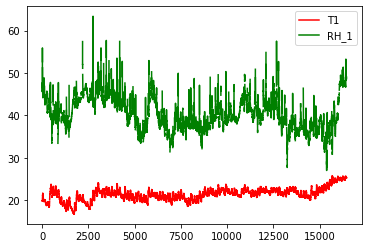

In [606]:
# ensure the missing block of data is now removed
xaxis = df.index.tolist()
plt.plot(xaxis, df['T1'], linestyle='-', color='r', label='T1')
plt.plot(xaxis, df['RH_1'], linestyle='-', color='g', label='RH_1')
plt.legend(loc='upper right')
plt.show()

In [608]:
impute_missing_features = df.median()

At this stage, there is no missing data in <i>Appliances</i> column. However, there are still some missing data in the other features. Finally, we impute the missing data in the remaining features using their respective medians.

In [609]:
df = df.fillna(impute_missing_features)

## 1.3 Feature Engineering and Data Transformation

We want to design and engineer features that best represent the underlying problem to the predictive model. In order to ensure a normal distribution of feature values, we examine the magnitude of skewness and kurtosis present of the empirical distribution of the given data. The idea being highly skewed features are not ideal for machine learning modelling, we want the data to be approximately symmetric and normally distributed.

A closer look into the feature values indicate a considerable skew and kurtosis in each of the data attributes. For example, as we can see below, the target variable <i>Appliances</i> has almost all the density below 250 whereas the range spans from a minimum value of 10 to a maximum of 1080 thereby exhibiting major skewness. Similarly, few other features which are skewed include T2, RH_5, T6, Windspeed, etc.

In [612]:
skewness = []
kurtosis_list= []
plot_columns = [col for col in df.columns.tolist() if col != 'date']
for col in plot_columns:
    v = df[col] - df[col].min() + 1
    v = v[~v.isna()]
    skewness.append(skew(v))
    kurtosis_list.append(kurtosis(v))

df_skew = pd.DataFrame.from_dict({'feature': plot_columns, 'skewness': skewness, 'kurtosis': kurtosis_list})
df_skew.sort_values('skewness', ascending=False)

,feature,skewness,kurtosis
0,Appliances,3.425027,14.023286
1,lights,2.144493,4.252704
10,RH_5,2.045629,5.407095
4,T2,1.209587,2.683740
20,Windspeed,0.917564,0.601982
11,T6,0.749443,1.646852
7,RH_3,0.584474,-0.344230
9,T5,0.555350,1.229576
17,RH_9,0.481418,-0.051385
3,RH_1,0.463738,0.600165


We now look at transformed versions of the distribution of feature values using two approaches:
* Log transformation
* Boxcox transformation
    
A illustration of these effects are presented below.

Appliances: skew = 3.4250269859193363 ; kurtosis = 14.023286464076929


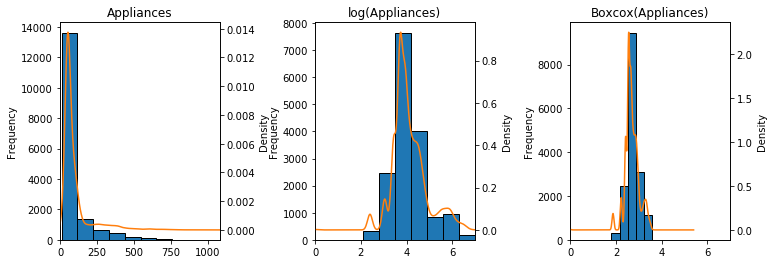

lights: skew = 2.1444925745922556 ; kurtosis = 4.2527043779391756


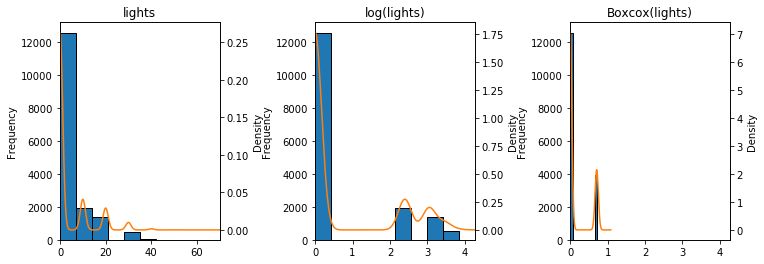

T1: skew = 0.12768504013997461 ; kurtosis = 1.277110088738194


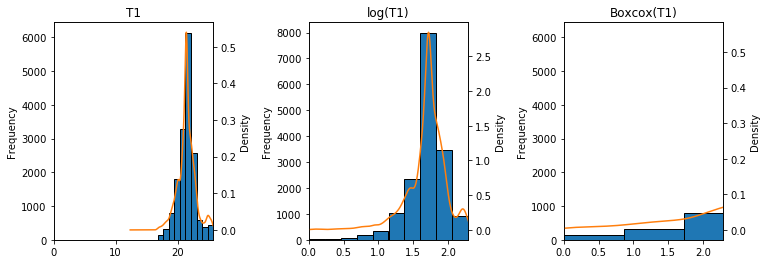

RH_1: skew = 0.46373770708117834 ; kurtosis = 0.6001652440870715


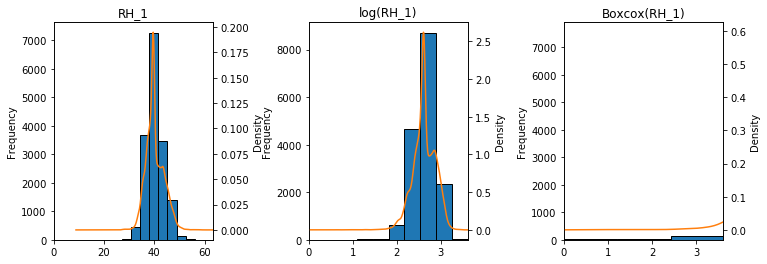

T2: skew = 1.209587293920069 ; kurtosis = 2.683740037771133


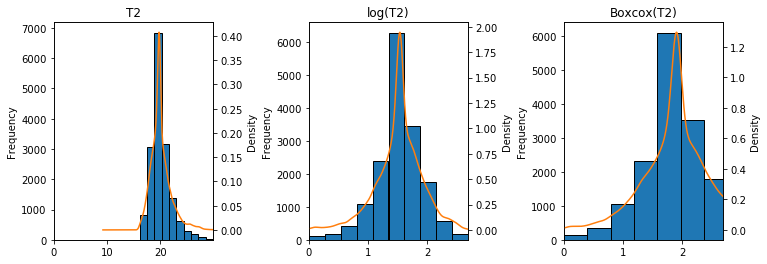

RH_2: skew = -0.5662917270412477 ; kurtosis = 1.3637193042107425


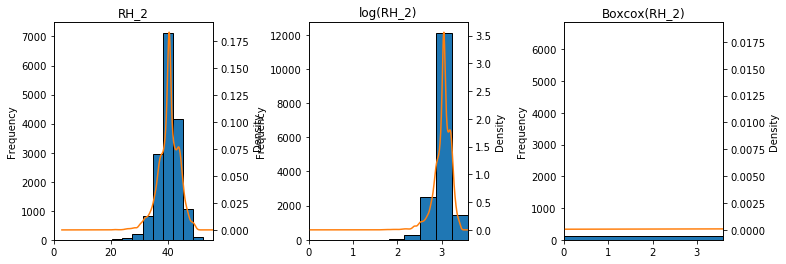

T3: skew = 0.44425942645000843 ; kurtosis = 0.8461690036520229


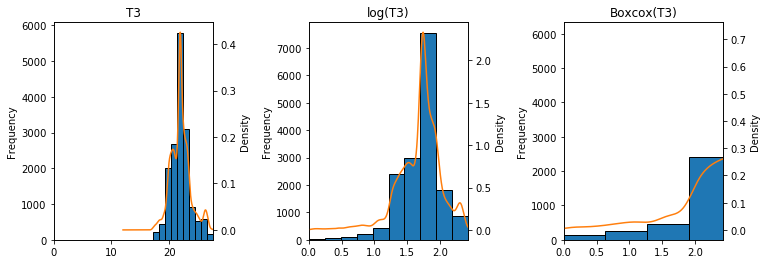

RH_3: skew = 0.584474124324553 ; kurtosis = -0.34422992148034925


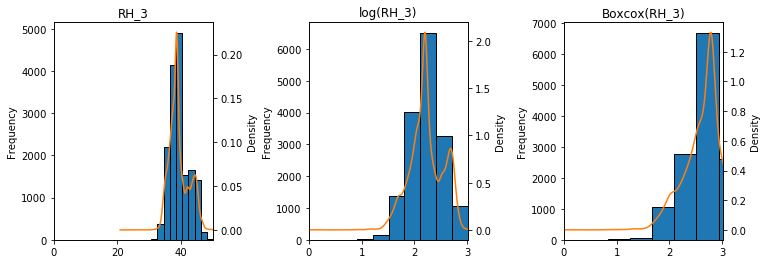

T4: skew = 0.276085929881216 ; kurtosis = 1.0415049663909617


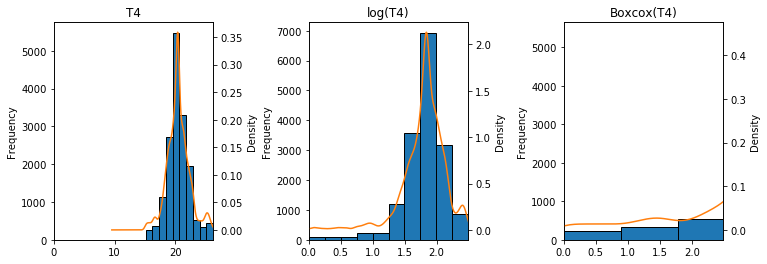

T5: skew = 0.5553503641909694 ; kurtosis = 1.229575871141206


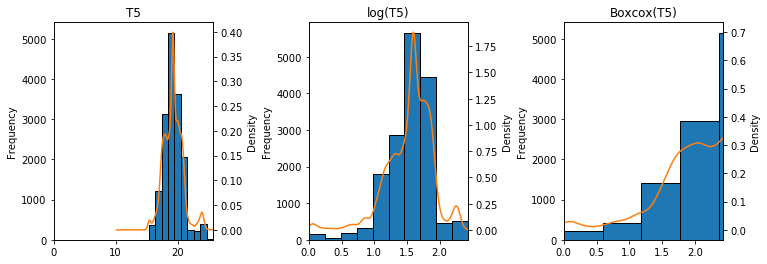

RH_5: skew = 2.0456286285652086 ; kurtosis = 5.407095331857697


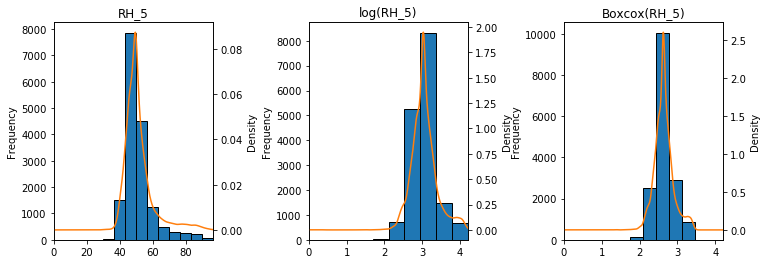

T6: skew = 0.7494426050918496 ; kurtosis = 1.6468520419406225


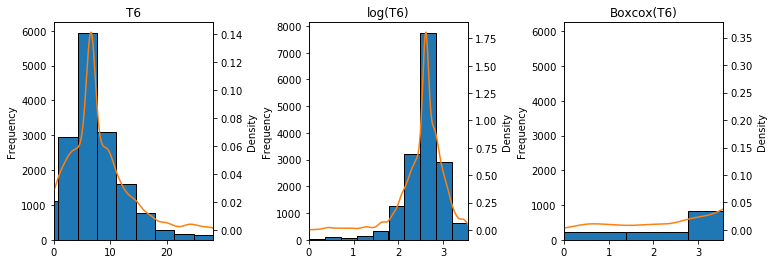

RH_6: skew = -0.49776330167597804 ; kurtosis = -0.7447035203376999


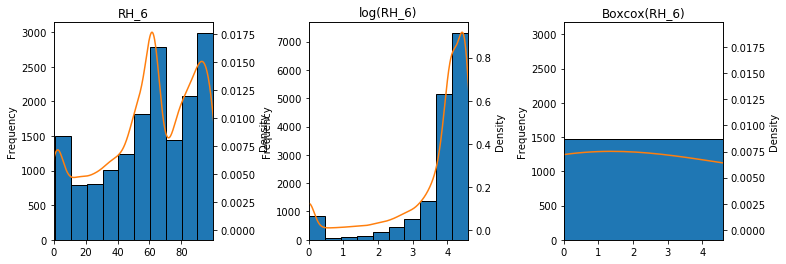

T7: skew = 0.4309632829276677 ; kurtosis = 0.6635385686759205


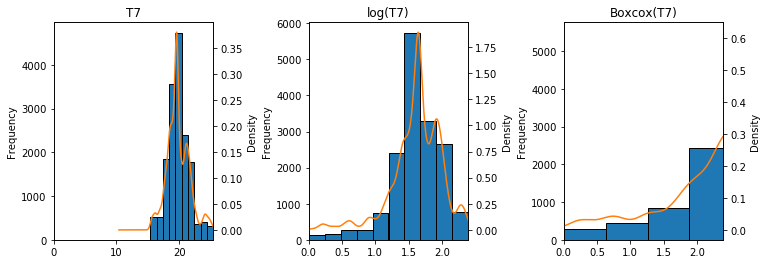

RH_7: skew = 0.44008529449429784 ; kurtosis = 0.115096257994316


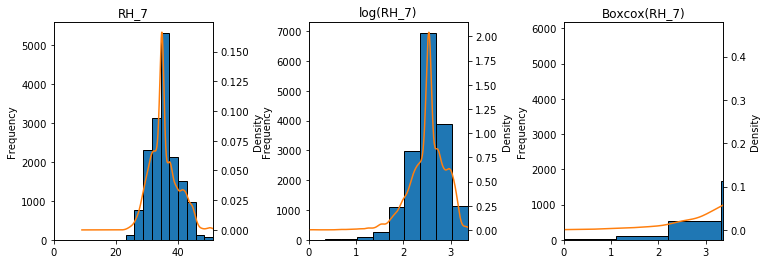

T8: skew = -0.24452660534004894 ; kurtosis = 0.48181271158181893


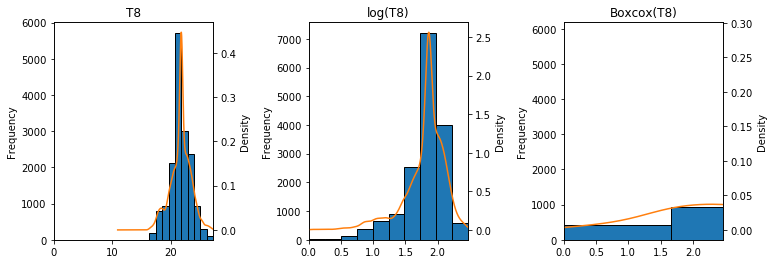

RH_8: skew = 0.4477727080454656 ; kurtosis = -0.2114767961521311


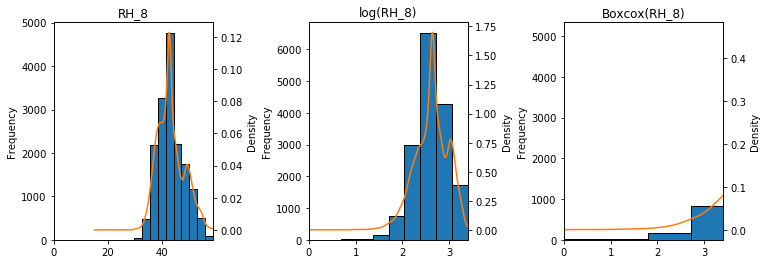

RH_9: skew = 0.4814176516827124 ; kurtosis = -0.05138467534134472


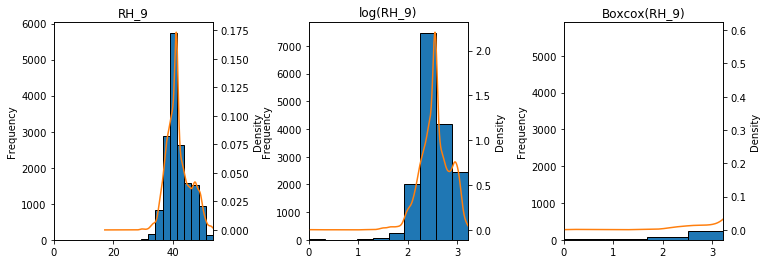

Press_mm_hg: skew = -0.41079722099655397 ; kurtosis = 0.5325340704493211


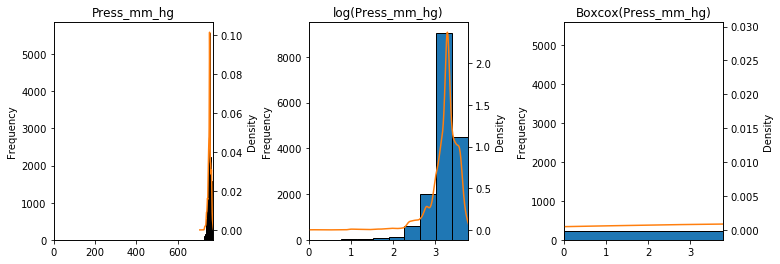

RH_out: skew = -1.1589534410000757 ; kurtosis = 1.1047004743463456


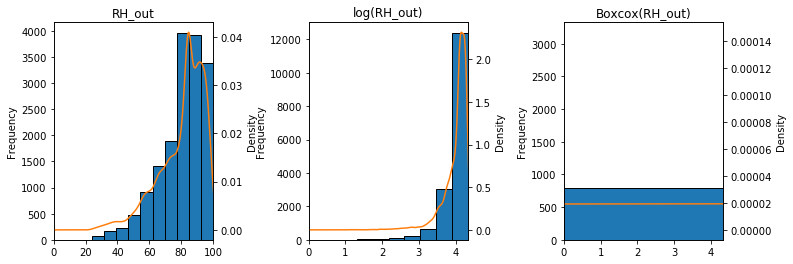

Windspeed: skew = 0.9175635238986233 ; kurtosis = 0.601981865331505


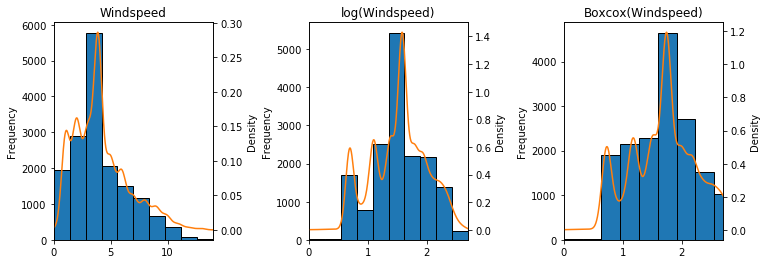

Visibility: skew = 0.4399670443102317 ; kurtosis = 0.7834357190363823


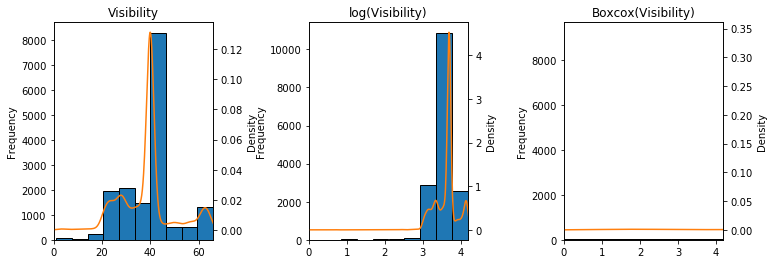

Tdewpoint: skew = 0.16193795976956524 ; kurtosis = 0.5218235007082725


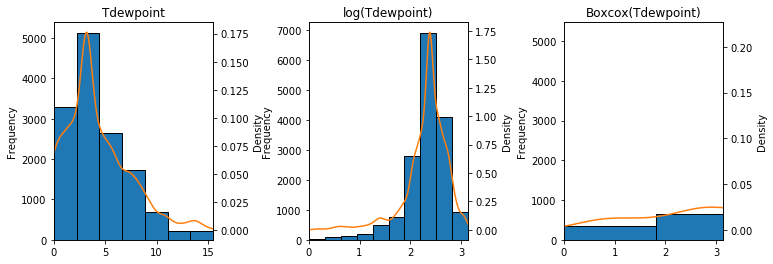

v1: skew = 0.0107796208597918 ; kurtosis = -1.2067985738831417


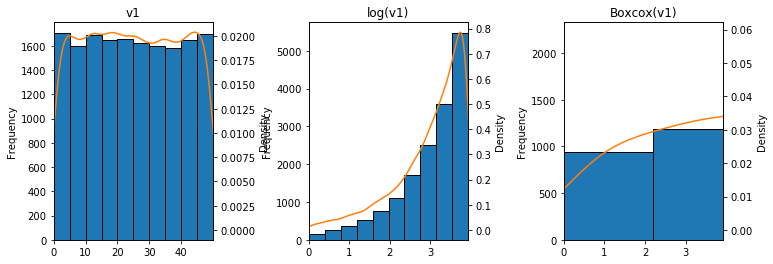

In [613]:
plot_columns = [col for col in df.columns.tolist() if col != 'date']
for col in plot_columns:
    fig = plt.figure(figsize=(12, 4))
    plt.subplots_adjust(wspace=0.6)
    
    plt.subplot(1, 3, 1)
    v = df[col]
    ax = v.plot(kind='hist', edgecolor='black')
    ax2 = v.plot(kind='kde', ax=ax, secondary_y=True, xlim=[0, max(v)])
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Density')
    ax.set_title(col)

    # ensure v values are positive for log & Boxcox transformations
    v = df[col] - df[col].min() + 1
    v = v[~v.isna()]
    col_skew = skew(v)
    col_kurtosis = kurtosis(v)
    
    plt.subplot(1, 3, 2)
    ax = np.log(v).plot(kind='hist', edgecolor='black')
    ax2 = np.log(v).plot(kind='kde', ax=ax, secondary_y=True, xlim=[0, max(np.log(v))])
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Density')
    ax.set_title('log(' + col + ')')
    
    plt.subplot(1, 3, 3)
    l, opt_lambda = boxcox(v)
    print(col + ': skew =', col_skew, '; kurtosis =', col_kurtosis)
    vt = pd.Series(boxcox(v, lmbda=opt_lambda))
    ax = vt.plot(kind='hist', edgecolor='black')
    ax2 = vt.plot(kind='kde', ax=ax, secondary_y=True, xlim=[0, max(np.log(v))])
    ax.set_ylabel('Frequency')
    ax2.set_ylabel('Density')
    ax.set_title('Boxcox(' + col + ')')
    
    plt.show()

### Log transformation of skewed feature distributions

We now apply <b>log transformations</b> on features which have <b>high skew or kurtosis</b>. I am using a threshold of +/- 1 to indicate a feature distribution is skewed. Below is the list of features which are deemed to be either skewed or hve high kurtosis. These <b>features</b> are:
* Appliances
* lights
* T1
* T2
* RH_2
* T4
* T5
* RH_5
* T6
* RH_out
* v1

In [614]:
df_ans = df_skew[ np.logical_or(df_skew['skewness'].abs() > 1.0, df_skew['kurtosis'].abs() > 1.0) ]
df_ans

,feature,skewness,kurtosis
0,Appliances,3.425027,14.023286
1,lights,2.144493,4.252704
2,T1,0.127685,1.277110
4,T2,1.209587,2.683740
5,RH_2,-0.566292,1.363719
8,T4,0.276086,1.041505
9,T5,0.555350,1.229576
10,RH_5,2.045629,5.407095
11,T6,0.749443,1.646852
19,RH_out,-1.158953,1.104700


In [620]:
log_transformed_features = df_ans['feature'].tolist()
log_transformed_features

['Appliances',
 'lights',
 'T1',
 'T2',
 'RH_2',
 'T4',
 'T5',
 'RH_5',
 'T6',
 'RH_out',
 'v1']

In [621]:
def compute_log_transform(v, subtract_min=1, add_one=0):
    vt = v
    if (subtract_min):
        vt = vt - v.min()
    if (add_one):
        vt = vt + 1
    return np.log(vt)

# log transformation of selected features in a dataframe
def compute_log_transform_features(X, features, subtract_min=1, add_one=0):
    Xt = X.copy()
    for col in features:
        vt = compute_log_transform(X[col], subtract_min, add_one)
        Xt[col] = vt
    return (Xt)

In [622]:
df_working = df.copy()
df_working['Appliances'] = compute_log_transform(df_working['Appliances'], subtract_min=0, add_one=0)
log_transformed_features.remove('Appliances')
df_working = compute_log_transform_features(df_working, log_transformed_features, subtract_min=1, add_one=1)

In [623]:
print(df_working.shape)
df_working.head()

(16459, 25)


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1
0,2016-01-11 17:00:00,4.094345,3.433987,1.410987,47.596667,1.410987,3.226579,19.79,44.730000,1.589235,1.042630,3.272796,2.643097,84.256667,17.200000,41.626667,18.20,48.900000,45.53,733.5,4.234107,7.000000,63.000000,5.3,2.658167
1,2016-01-11 17:10:00,4.094345,3.433987,1.410987,46.693333,1.410987,3.223897,19.79,44.790000,1.589235,1.042630,3.272796,2.629247,84.063333,17.200000,41.560000,21.79,48.863333,45.56,733.6,4.234107,6.666667,40.000000,5.2,2.975574
2,2016-01-11 17:20:00,3.912023,3.433987,1.410987,46.300000,1.410987,3.220075,19.79,44.933333,1.574156,1.042630,3.268618,2.609334,83.156667,17.200000,41.433333,18.20,48.730000,45.50,755.0,4.234107,6.333333,55.333333,5.1,3.389035
3,2016-01-11 17:30:00,3.912023,3.713572,1.410987,46.066667,1.410987,3.218609,19.79,45.000000,1.566530,1.042630,3.268618,2.599970,83.423333,17.133333,41.290000,18.10,48.590000,45.40,733.8,4.116323,6.000000,51.500000,5.0,3.837409
4,2016-01-11 17:40:00,4.094345,3.713572,1.410987,46.333333,1.410987,3.216206,19.79,45.000000,1.566530,1.054312,3.268618,2.595006,84.893333,17.200000,34.927778,18.10,48.590000,45.40,733.9,4.116323,5.666667,47.666667,4.9,2.405031


## 1.4 Adding extra features derived from the timestamp

Given electricity usage as a time series data, one would expect the usage depends on the time of the day. For example, in most households, electricity usage would be relatively low during work hours and would reach peak usage in the evening/night time. Further, electricity usage could also depend on the day of the week as there is expected to be varying usage patterns during weekend/weekdays. Hence, I augment the data to capture this potential variation by deriving the time and the day of the week from the timestamp as shown below.

In [624]:
df_working['Weekday'] = df_working['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%a'))
df_working['Hour'] = df_working['date'].map(lambda x: 'H' + datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))
df_working.set_index('date', inplace=True)

### One-hot encoding of categorical features

The inclusion of <b>Weekday</b> and <b>Hour</b> features which are <i>categorical</i> in nature motivates us to perform a one-hot encoding of these two so we can build machine learning models on the numeric dataset.

In [625]:
# One hot encoding of a list of features in a DataFrame
def one_hot_encoding(X, cat_col_list, encoding_cat=None):
    df_cat = X[cat_col_list]

    if encoding_cat is None:
        encoding_cat = OneHotEncoder()
        encoding_cat.fit(df_cat)
        
    df_cat_enc = pd.DataFrame(
            encoding_cat.transform(df_cat).toarray(), columns=encoding_cat.get_feature_names()
    )
    df_cat_enc.set_index(df_cat.index, inplace=True)
    Xt = pd.merge(X, df_cat_enc, how='left', left_index=True, right_index=True)
    Xt = Xt.drop(cat_col_list, axis=1)
    
    return (Xt, encoding_cat)

In [626]:
df_working, encoding_cat = one_hot_encoding(df_working, ['Weekday', 'Hour'])
print(df_working.shape)
df_working.head()

(16459, 55)


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,x0_Fri,x0_Mon,x0_Sat,x0_Sun,x0_Thu,x0_Tue,x0_Wed,x1_H00,x1_H01,x1_H02,x1_H03,x1_H04,x1_H05,x1_H06,x1_H07,x1_H08,x1_H09,x1_H10,x1_H11,x1_H12,x1_H13,x1_H14,x1_H15,x1_H16,x1_H17,x1_H18,x1_H19,x1_H20,x1_H21,x1_H22,x1_H23
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,4.094345,3.433987,1.410987,47.596667,1.410987,3.226579,19.79,44.730000,1.589235,1.042630,3.272796,2.643097,84.256667,17.200000,41.626667,18.20,48.900000,45.53,733.5,4.234107,7.000000,63.000000,5.3,2.658167,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-11 17:10:00,4.094345,3.433987,1.410987,46.693333,1.410987,3.223897,19.79,44.790000,1.589235,1.042630,3.272796,2.629247,84.063333,17.200000,41.560000,21.79,48.863333,45.56,733.6,4.234107,6.666667,40.000000,5.2,2.975574,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-11 17:20:00,3.912023,3.433987,1.410987,46.300000,1.410987,3.220075,19.79,44.933333,1.574156,1.042630,3.268618,2.609334,83.156667,17.200000,41.433333,18.20,48.730000,45.50,755.0,4.234107,6.333333,55.333333,5.1,3.389035,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-11 17:30:00,3.912023,3.713572,1.410987,46.066667,1.410987,3.218609,19.79,45.000000,1.566530,1.042630,3.268618,2.599970,83.423333,17.133333,41.290000,18.10,48.590000,45.40,733.8,4.116323,6.000000,51.500000,5.0,3.837409,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-11 17:40:00,4.094345,3.713572,1.410987,46.333333,1.410987,3.216206,19.79,45.000000,1.566530,1.054312,3.268618,2.595006,84.893333,17.200000,34.927778,18.10,48.590000,45.40,733.9,4.116323,5.666667,47.666667,4.9,2.405031,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Machine Learning Modelling

For building a machine learning model, we need to infer its optimal parameters as part of the model training phase. We also use cross-validation to iterate through various hyperparameter combinations to determine the optimal set of hyperparameters to be used in the model construction process.

The below steps, mainly the <mark>build_optimal_model()</mark> function below performs the K-fold cross-validation using the parameter <mark>GridSearch()</mark> functionality to achieve this.

We demonstrate the model building and prediction steps using the following predictive models in this notebook:
* Linear model (using Ridge regression)
* Extreme gradient boosting (Xgboost) model

(I have experimented with other ML models during development which I have omitted from this main notebook. They are however included along with the solution package for perusal).

In [627]:
# using RMSE as the cost function to minimize
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [628]:
# the RMSE metric is used during cross validation to determine the optimal hyperparameters of the machine learning model
scoring = make_scorer(root_mean_squared_error, greater_is_better=False)

In [629]:
#-------------------------------------------------------------------------------
# Execute the cross-validation for all parameter combinations and computes the
# evaluation metric (in this case RMSE). At each iteration of the cross validation  
# process, the model is evaluated using RMSE and the optimal set of hyperparameters  
# and the optimal model is determined.
#-------------------------------------------------------------------------------
def build_optimal_model(model_type, model, model_parameter_grid, X, y, scoring):
    grid_object = GridSearchCV(model, param_grid=model_parameter_grid, cv=5, scoring=scoring, refit=True, return_train_score=True, n_jobs=-1)
    print('Performing grid search to determine the optimal parameters ...')
    grid_object.fit(X, y)
    grid_search_output = pd.DataFrame(grid_object.cv_results_)

    optimal_model = grid_object.best_estimator_
    optimal_model = optimal_model.fit(X, y)

    return grid_object, grid_search_output, optimal_model

In [697]:
# Construct the training data set
# X: list of all training features (post data transformation steps as described previously)
# y: target variable (Appliances) for prediction
all_columns = df_working.columns.tolist()
y = df_working['Appliances']

all_columns.remove('Appliances')
X = df_working[all_columns]

### Linear model using Ridge regression

In [631]:
%%time

# Ridge regression setup
model_type = 'Linear Model'
model = Ridge(copy_X=False)
model_parameter_grid = {
         'normalize': [True, False],
         'alpha': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1]
        }

grid_object, grid_search_output, optimal_linear_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, scoring)

print(-grid_object.best_score_)
print(grid_object.best_params_)
pd.DataFrame.from_dict({'feature': X.columns.tolist(), 'coef': optimal_linear_model.coef_}).sort_values('coef', ascending=False)

Performing grid search to determine the optimal parameters ...
0.5598364645403844
{'alpha': 0.1, 'normalize': True}
CPU times: user 900 ms, sys: 167 ms, total: 1.07 s
Wall time: 6.32 s


,feature,coef
0,lights,15.442268
48,x1_H18,13.744807
5,T3,12.844111
47,x1_H17,9.414968
49,x1_H19,8.445540
14,T8,8.282509
6,RH_3,8.189306
50,x1_H20,5.543941
41,x1_H11,5.338621
42,x1_H12,5.163405


### Extreme gradient boosting technique

In [672]:
%%time

# Xgboost setup
model_type = 'Xgboost'
model = XGBRegressor(
    random_state=1, n_estimators=100, objective='reg:squarederror', booster='gbtree', max_depth=5
)
model_parameter_grid = {
         'reg_alpha': [0.05, 0.1, 0.2, 0.3],
         'reg_lambda': [0.05, 0.1, 0.2, 0.3]
        }

grid_object, grid_search_output, optimal_xgboost_model = build_optimal_model(model_type, model, model_parameter_grid, X, y, scoring)

print(-grid_object.best_score_)
print(grid_object.best_params_)

Performing grid search to determine the optimal parameters ...


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.6069387687798188
{'reg_alpha': 0.1, 'reg_lambda': 0.3}
CPU times: user 10.2 s, sys: 222 ms, total: 10.5 s
Wall time: 4min 2s


In [674]:
df_feature_importance = pd.DataFrame.from_dict({'feature': X.columns.tolist(), 'importance': optimal_xgboost_model.feature_importances_}).sort_values('importance', ascending=False)
df_feature_importance['normalized_importance'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance['cumulative_importance'] = np.cumsum(df_feature_importance['normalized_importance'])
df_feature_importance

,feature,importance,normalized_importance,cumulative_importance
0,lights,0.067013,0.067013,0.067013
48,x1_H18,0.062285,0.062285,0.129297
49,x1_H19,0.050577,0.050577,0.179875
47,x1_H17,0.040845,0.040845,0.220719
50,x1_H20,0.040037,0.040037,0.260757
30,x1_H00,0.038335,0.038335,0.299092
33,x1_H03,0.036541,0.036541,0.335632
31,x1_H01,0.035321,0.035321,0.370953
32,x1_H02,0.034811,0.034811,0.405763
53,x1_H23,0.034709,0.034709,0.440472


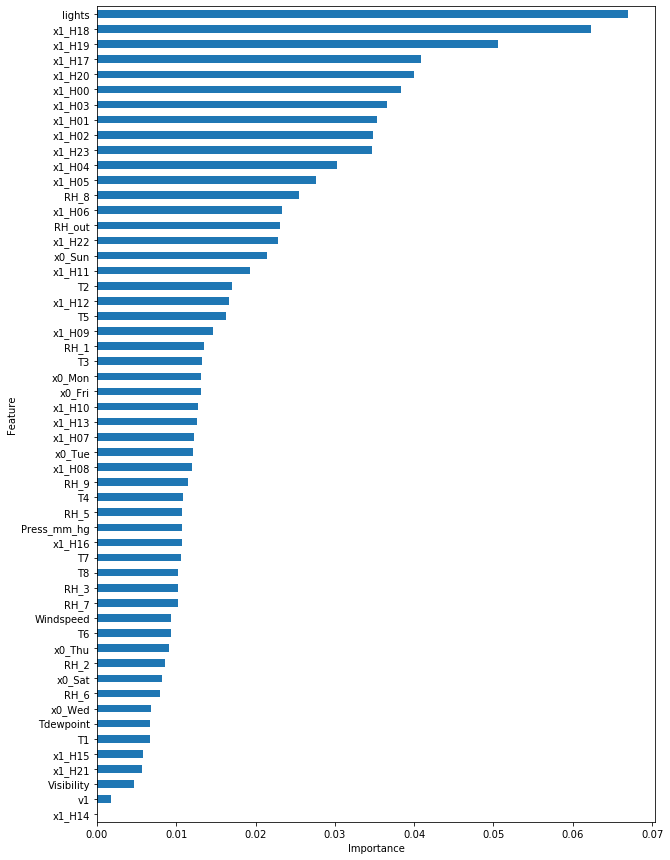

In [685]:
figure = plt.figure(figsize=(10, 15))
ax = df_feature_importance['importance'][::-1].plot(kind='barh')
plt.yticks(range(len(df_feature_importance))[::-1], df_feature_importance['feature'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

The output of the Xgboost model and the corresponding top contributing features indicate the target variable <i>Appliances</i> is strongly affected/influenced by:
* <mark>lights</mark>: clearly more usage of light fixtures results in higher electricity consumption
* <mark>x1_H18, x1_H19, x1_H17, x1_H20, x1_H23</mark>: usage during the evening to late night hours (time of the day) is directly proportional to increased electricity consumption
* <mark>x1_H00, x1_H01, x1_H02, x1_H03, x1_H04, x1_H05</mark>: usage is affected by the time of the night, potentially less usage during midnight to early morning hours
* <mark>RH_8, RH_out</mark>: relative humidity in teenager's room and outside respectively directly influences electricity consumption
* <mark>x0_Sun</mark>: Sunday usage is potentially more 
* <mark>x0_Wed, x0_Sat, Visibiltiy, v1, x1_H14</mark>: some of the less contributing features

## Model Performance 

> #### Task:
- **Compute your selected model in the Modelling Task with the two metrics described as following**:<br>
    - R-Squared <br>
    $ R^2 = 1 - \frac{\text{Explained Variation}}{\text{Total Variation}}$
    - Root-Mean-Square-Error <br>    
    $ RMSE = \sqrt{\frac{\sum (\text{Predicted}_i - \text{Actual}_i)^2}{a}}$

> #### Deliverables:
- Report the $R^2$ and $RMSE$ values in the `Question 2 Model Performance` .


In [669]:
# Linear model with Ridge regression
print('Performance of the Linear model using ridge regression')
predicted = optimal_linear_model.predict(X)

# RMSE on the transformed data features
#print(root_mean_squared_error(predicted, y)) 

# RMSE on the original (training) data features
print('RMSE: ', root_mean_squared_error(np.exp(predicted), np.exp(y)))

# R^2 on the transformed data features
#print(r2_score(y, predicted))

# R^2 on the original (training) data features
print('R^2:', r2_score(np.exp(y), np.exp(predicted)))

Performance of the Linear model using ridge regression
RMSE:  95.08711707237502
R^2: 0.13138270241332628


In [671]:
# Xgboost model evaluation
print('Performance of the Xgboost model')
predicted = optimal_xgboost_model.predict(X)

# RMSE on the transformed data features
#print(root_mean_squared_error(predicted, y))

# RMSE on the original (training) data features
print('RMSE: ', root_mean_squared_error(np.exp(predicted), np.exp(y)))

# R^2 on the transformed data features
#print(r2_score(y, predicted))

# R^2 on the original (training) data features
print('R^2:', r2_score(np.exp(y), np.exp(predicted)))

Performance of the Xgboost model
RMSE:  80.6480892090248
R^2: 0.3751535924438689


## Prediction Task

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the second dataset (`dataset_2.csv`), you must predict the value of the `Appliances` variable. You should submit a CSV file with a header row and one row per test entry.

> #### Deliverable:
- The file (`submissions.csv`) should have exactly 2 columns:
   - **date**
   - **Appliances** 

> #### Submission option:
- you could either export your result in this notebook, for example: 
```
 submission_df.to_csv('submissions.csv',index=False)```
- Alternatively you could use the `upload file` option in the menu section on the left side of this notebook.

### Summary of steps for preparing the data required for machine learning modelling and prediction on test data

* <b>Step 1:</b> Exclude columns ['RH_4', 'T9', 'T_out', 'v2'] from the dataset
* <b>Step 2:</b> Impute missing values in the remaining features with their medians from the training phase.
* <b>Step 3:</b> Apply log transformation for the following features: ['lights', 'T1', 'T2', 'RH_2', 'T4', 'T5', 'RH_5', 'T6', 'RH_out', 'v1']]
* <b>Step 4:</b> Derive categorical features of Weekday & Hour from the timestamp and include them as extra features
* <b>Step 5:</b> Apply one-hot encoding of these two categorical features to create a numeric dataset

In [638]:
df_test_raw = pd.read_csv('dataset_2.csv', header='infer')
df_test_raw.drop('index', axis=1, inplace=True)

print(df_test_raw.shape)
df_test_raw.head()

(2125, 28)


,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,v2
0,2016-05-13 00:00:00,0.0,25.29,48.59,23.671429,49.368571,26.500000,44.59,25.272000,45.79,24.1,51.060000,14.226667,NaN,24.89,NaN,NaN,51.078750,24.157143,47.700000,14.100000,745.500000,91.0,1.000000,22.000000,12.600000,8.987029,8.987029
1,2016-05-13 00:10:00,0.0,25.29,48.59,23.600000,49.400000,26.600000,44.59,25.225714,45.79,24.1,51.000000,14.360000,52.333333,24.89,43.09,26.671429,51.064286,24.140000,47.700000,14.266667,745.566667,91.5,1.333333,25.833333,12.866667,21.038167,21.038167
2,2016-05-13 00:20:00,0.0,25.29,48.53,23.600000,49.485714,26.533333,44.59,25.290000,45.79,24.1,51.000000,14.563333,53.733333,24.89,43.09,26.600000,51.054000,24.171429,47.700000,NaN,NaN,NaN,NaN,NaN,NaN,32.205595,32.205595
3,2016-05-13 00:30:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.600000,745.700000,92.5,2.000000,33.500000,13.400000,3.169344,3.169344
4,2016-05-13 00:40:00,0.0,NaN,48.50,23.500000,49.725714,26.600000,NaN,25.200000,45.90,24.1,50.966667,14.890000,54.700000,24.89,43.09,26.520000,50.900000,24.200000,47.751429,14.766667,NaN,93.0,2.333333,37.333333,13.666667,24.575982,24.575982


In [657]:
df_test = df_test_raw.copy()

# Step 1
df_test.drop(['RH_4', 'T9', 'T_out', 'v2'], axis=1, inplace=True)

# Step 2
if 'Appliances' in impute_missing_features.tolist():
    impute_missing_features.remove('Appliances')
df_test.fillna(impute_missing_features, inplace=True)

# Step 3
df_test = compute_log_transform_features(
            df_test, ['lights', 'T1', 'T2', 'RH_2', 'T4', 'T5', 'RH_5', 'T6', 'RH_out', 'v1'], subtract_min=1, add_one=1
          )

# Step 4
df_test['Weekday'] = df_test['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%a'))
df_test['Hour'] = df_test['date'].map(lambda x: 'H' + datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))
df_test.set_index('date', inplace=True)

# Step 5
df_test, encoding_cat = one_hot_encoding(df_test, ['Weekday', 'Hour'], encoding_cat)

In [658]:
print(df_test.shape)
df_test.head()

(2125, 54)


,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1,x0_Fri,x0_Mon,x0_Sat,x0_Sun,x0_Thu,x0_Tue,x0_Wed,x1_H00,x1_H01,x1_H02,x1_H03,x1_H04,x1_H05,x1_H06,x1_H07,x1_H08,x1_H09,x1_H10,x1_H11,x1_H12,x1_H13,x1_H14,x1_H15,x1_H16,x1_H17,x1_H18,x1_H19,x1_H20,x1_H21,x1_H22,x1_H23
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-13 00:00:00,0.0,1.589235,48.590000,1.591565,3.046901,26.500000,44.59,1.771897,1.774952,2.731767,2.589767,62.261667,24.89,34.927778,21.790000,51.078750,47.700000,745.500000,3.871201,1.000000,22.000000,12.600000,2.298307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-13 00:10:00,0.0,1.589235,48.590000,1.576915,3.048392,26.600000,44.59,1.763997,1.774952,2.727853,2.599722,52.333333,24.89,43.090000,26.671429,51.064286,47.700000,745.566667,3.881564,1.333333,25.833333,12.866667,3.091426,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-13 00:20:00,0.0,1.589235,48.530000,1.576915,3.052450,26.533333,44.59,1.774952,1.774952,2.727853,2.614716,53.733333,24.89,43.090000,26.600000,51.054000,47.700000,755.000000,3.721669,3.833333,40.000000,3.200000,3.501823,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-13 00:30:00,0.0,0.000000,39.626667,0.000000,2.507274,21.890000,38.73,0.000000,0.058269,2.617396,1.750359,62.261667,19.60,34.927778,21.790000,42.600000,41.000000,745.700000,3.901973,2.000000,33.500000,13.400000,1.420605,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-13 00:40:00,0.0,0.000000,48.500000,1.556037,3.063725,26.600000,38.73,1.759581,1.774952,2.725672,2.638343,54.700000,24.89,43.090000,26.520000,50.900000,47.751429,755.000000,3.912023,2.333333,37.333333,13.666667,3.240491,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [661]:
# Predictions due to the Linear (Ridge) Regression model
predicted = optimal_linear_model.predict(df_test)
linear_model_predictions = np.exp(predicted)

In [662]:
# Predictions due to the Xgboost model
predicted = optimal_xgboost_model.predict(df_test)
xgboost_model_predictions = np.exp(predicted)

In [664]:
submission_df = pd.DataFrame.from_dict({'date': df_test.index.tolist(), 'Appliances': xgboost_model_predictions})
print(submission_df.shape)
submission_df.head()

(2125, 2)


,date,Appliances
0,2016-05-13 00:00:00,91.176849
1,2016-05-13 00:10:00,91.176849
2,2016-05-13 00:20:00,91.176849
3,2016-05-13 00:30:00,147.770142
4,2016-05-13 00:40:00,88.475830


In [665]:
# Submission (predictions of best performing Xgboost model)
submission_df.to_csv('submissions.csv',index=False)

## Appendix (FYI - do not consider for evaluation)

### Trying LSTM modelling - experimenting with Recurrent Neural Networks
https://en.wikipedia.org/wiki/Long_short-term_memory

Below code adopted from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

I'm including this approach just to cover the application of neural networks in modelling time series data. The results of LSTM modelling are not convincing for this problem.

In [701]:
# Construct the training data set
# X: list of all training features (post data transformation steps as described previously)
# y: target variable (Appliances) for prediction
all_columns = df_working.columns.tolist()
y = df_working['Appliances']

all_columns.remove('Appliances')
X = df_working[['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'RH_9', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'v1']]

In [705]:
print(X.shape)
X.head()

(16459, 23)


,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,RH_9,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,v1
date,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,3.433987,1.410987,47.596667,1.410987,3.226579,19.79,44.730000,1.589235,1.042630,3.272796,2.643097,84.256667,17.200000,41.626667,18.20,48.900000,45.53,733.5,4.234107,7.000000,63.000000,5.3,2.658167
2016-01-11 17:10:00,3.433987,1.410987,46.693333,1.410987,3.223897,19.79,44.790000,1.589235,1.042630,3.272796,2.629247,84.063333,17.200000,41.560000,21.79,48.863333,45.56,733.6,4.234107,6.666667,40.000000,5.2,2.975574
2016-01-11 17:20:00,3.433987,1.410987,46.300000,1.410987,3.220075,19.79,44.933333,1.574156,1.042630,3.268618,2.609334,83.156667,17.200000,41.433333,18.20,48.730000,45.50,755.0,4.234107,6.333333,55.333333,5.1,3.389035
2016-01-11 17:30:00,3.713572,1.410987,46.066667,1.410987,3.218609,19.79,45.000000,1.566530,1.042630,3.268618,2.599970,83.423333,17.133333,41.290000,18.10,48.590000,45.40,733.8,4.116323,6.000000,51.500000,5.0,3.837409
2016-01-11 17:40:00,3.713572,1.410987,46.333333,1.410987,3.216206,19.79,45.000000,1.566530,1.054312,3.268618,2.595006,84.893333,17.200000,34.927778,18.10,48.590000,45.40,733.9,4.116323,5.666667,47.666667,4.9,2.405031


In [704]:
values = X.values
values.shape

(16459, 23)

In [706]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg 

In [707]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [709]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# split into train and test sets
values = reframed.values
n_train = 13000 # 80%
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train, y[0:n_train].values
test_X, test_y = test, y[n_train+1:].values

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13000, 1, 46) (13000,) (3458, 1, 46) (3458,)


Train on 13000 samples, validate on 3458 samples
Epoch 1/50
 - 1s - loss: 2.8158 - val_loss: 0.4128
Epoch 2/50
 - 0s - loss: 0.4924 - val_loss: 0.3898
Epoch 3/50
 - 0s - loss: 0.4674 - val_loss: 0.3707
Epoch 4/50
 - 0s - loss: 0.4482 - val_loss: 0.3553
Epoch 5/50
 - 0s - loss: 0.4340 - val_loss: 0.3426
Epoch 6/50
 - 0s - loss: 0.4233 - val_loss: 0.3322
Epoch 7/50
 - 0s - loss: 0.4151 - val_loss: 0.3234
Epoch 8/50
 - 0s - loss: 0.4087 - val_loss: 0.3161
Epoch 9/50
 - 0s - loss: 0.4035 - val_loss: 0.3100
Epoch 10/50
 - 0s - loss: 0.3993 - val_loss: 0.3049
Epoch 11/50
 - 0s - loss: 0.3958 - val_loss: 0.3005
Epoch 12/50
 - 1s - loss: 0.3928 - val_loss: 0.2967
Epoch 13/50
 - 0s - loss: 0.3902 - val_loss: 0.2935
Epoch 14/50
 - 0s - loss: 0.3879 - val_loss: 0.2907
Epoch 15/50
 - 0s - loss: 0.3858 - val_loss: 0.2883
Epoch 16/50
 - 0s - loss: 0.3840 - val_loss: 0.2862
Epoch 17/50
 - 0s - loss: 0.3823 - val_loss: 0.2844
Epoch 18/50
 - 0s - loss: 0.3808 - val_loss: 0.2828
Epoch 19/50
 - 0s - loss

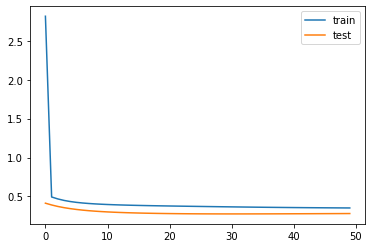

CPU times: user 36 s, sys: 998 ms, total: 37 s
Wall time: 24.5 s


In [710]:
%%time 

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [712]:
# model evaluation
print('Performance of the LSTM model')
predicted = model.predict(test_X)

#print(root_mean_squared_error(predicted, test_y))
print('RMSE: ', root_mean_squared_error(np.exp(predicted), np.exp(test_y)))

#print(r2_score(test_y, predicted))
print('R^2: ', r2_score(np.exp(test_y), np.exp(predicted)))

Performance of the LSTM model
RMSE:  83.6812515465174
R^2:  0.010420413129648476


LSTM results in a poor performance compared to the Xgboost model in this case